In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import wrangle

from sklearn.model_selection import train_test_split

# Data Acquisition

In [2]:
df = wrangle.get_zillow_data()

df.head()

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id,logerror,transactiondate
0,14634203,2026522,1.0,NaN,NaN,2.0,3.0,None,NaN,2.0,...,289445.0,2016.0,213516.0,3490.16,None,NaN,6.059001e+13,625,-0.061973,2017-08-04
1,11721753,616260,NaN,NaN,NaN,2.0,3.0,None,6.0,2.0,...,205123.0,2016.0,163175.0,2627.48,None,NaN,6.037220e+13,1018,0.017785,2017-07-21
2,11289917,2061546,1.0,NaN,NaN,2.0,3.0,None,6.0,2.0,...,136104.0,2016.0,27214.0,2319.90,Y,15.0,6.037901e+13,1248,-0.362001,2017-06-23
3,11637029,2554497,1.0,NaN,NaN,2.0,3.0,None,9.0,2.0,...,810694.0,2016.0,554156.0,9407.01,Y,13.0,6.037701e+13,1734,-0.093399,2017-07-28
4,11705026,1834372,NaN,NaN,NaN,1.0,2.0,None,6.0,1.0,...,35606.0,2016.0,23624.0,543.69,None,NaN,6.037232e+13,1772,-0.146056,2017-06-30


In [3]:
df = wrangle.cached_zillow()
df.head()

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id,logerror,transactiondate
0,14634203,2026522,1.0,NaN,NaN,2.0,3.0,None,NaN,2.0,...,289445.0,2016.0,213516.0,3490.16,None,NaN,6.059001e+13,625,-0.061973,2017-08-04
1,11721753,616260,NaN,NaN,NaN,2.0,3.0,None,6.0,2.0,...,205123.0,2016.0,163175.0,2627.48,None,NaN,6.037220e+13,1018,0.017785,2017-07-21
2,11289917,2061546,1.0,NaN,NaN,2.0,3.0,None,6.0,2.0,...,136104.0,2016.0,27214.0,2319.90,Y,15.0,6.037901e+13,1248,-0.362001,2017-06-23
3,11637029,2554497,1.0,NaN,NaN,2.0,3.0,None,9.0,2.0,...,810694.0,2016.0,554156.0,9407.01,Y,13.0,6.037701e+13,1734,-0.093399,2017-07-28
4,11705026,1834372,NaN,NaN,NaN,1.0,2.0,None,6.0,1.0,...,35606.0,2016.0,23624.0,543.69,None,NaN,6.037232e+13,1772,-0.146056,2017-06-30


In [4]:
df = wrangle.cached_zillow(cached=True)
df.head()

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,logerror,transactiondate
0,14634203,2026522,1.0,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,289445.0,2016.0,213516.0,3490.16,NaN,NaN,6.059001e+13,625,-0.061973,2017-08-04
1,11721753,616260,NaN,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,205123.0,2016.0,163175.0,2627.48,NaN,NaN,6.037220e+13,1018,0.017785,2017-07-21
2,11289917,2061546,1.0,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,136104.0,2016.0,27214.0,2319.90,Y,15.0,6.037901e+13,1248,-0.362001,2017-06-23
3,11637029,2554497,1.0,NaN,NaN,2.0,3.0,NaN,9.0,2.0,...,810694.0,2016.0,554156.0,9407.01,Y,13.0,6.037701e+13,1734,-0.093399,2017-07-28
4,11705026,1834372,NaN,NaN,NaN,1.0,2.0,NaN,6.0,1.0,...,35606.0,2016.0,23624.0,543.69,NaN,NaN,6.037232e+13,1772,-0.146056,2017-06-30


### Initial Data Summarization

In [5]:
#rows and columns
df.shape

(38622, 62)

In [6]:
#list of column names and data types with more information
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38622 entries, 0 to 38621
Data columns (total 62 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      38622 non-null  int64  
 1   id                            38622 non-null  int64  
 2   airconditioningtypeid         12224 non-null  float64
 3   architecturalstyletypeid      101 non-null    float64
 4   basementsqft                  27 non-null     float64
 5   bathroomcnt                   38622 non-null  float64
 6   bedroomcnt                    38622 non-null  float64
 7   buildingclasstypeid           0 non-null      float64
 8   buildingqualitytypeid         23706 non-null  float64
 9   calculatedbathnbr             38463 non-null  float64
 10  decktypeid                    333 non-null    float64
 11  finishedfloor1squarefeet      3339 non-null   float64
 12  calculatedfinishedsquarefeet  38509 non-null  float64
 13  f

In [7]:
df.isnull().sum()

parcelid                        0
id                              0
airconditioningtypeid       26398
architecturalstyletypeid    38521
basementsqft                38595
                            ...  
taxdelinquencyyear          37354
censustractandblock           144
id.1                            0
logerror                        0
transactiondate                 0
Length: 62, dtype: int64

Text(0.5, 1.0, 'Distribution of square feet')

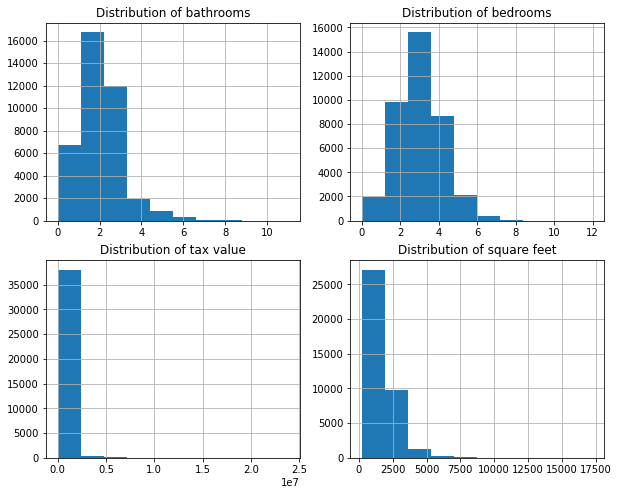

In [8]:
# use subplots to view distribution of numeric columns
plt.figure(figsize=(10, 8))

plt.subplot(221)
df.bathroomcnt.hist()
plt.gca().set_title('Distribution of bathrooms')


plt.subplot(222)
df.bedroomcnt.hist()
plt.gca().set_title('Distribution of bedrooms')

plt.subplot(223)
df.taxvaluedollarcnt.hist() 
plt.gca().set_title('Distribution of tax value')

plt.subplot(224)
df.calculatedfinishedsquarefeet.hist()
plt.gca().set_title('Distribution of square feet')


### Findings
- There are many, many nulls in this dataset. Setting a thresh hold can be done to remove columns with more than 25% nulls and filling in leftover nulls should be done to have no more nulls in dataset. 
- Column for age of property would be useful.
- Column names are too long and can be shortened/have better titles for readability.
- Some columns have repeated and/or unnecessary information so those will need to be removed as well. 
- Outliers exist in `taxvaluedollarcnt` and `calculatedfinishedsquarefeet` and can be removed by calculating IQR, upper bound and lower bound.
- Datatypes can be converted to integers for a cleaner dataframe. 
- Data should be scaled as well.